In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.options.display.max_rows = 25 
pd.options.display.max_columns = None

In [4]:
col_ignore = ['scheme_name', 'wpt_name', 'source_class', 'quality_group', 'quantity_group', 'recorded_by', 
             'extraction_type_group', 'extraction_type_class','management_group', 'payment_type', 'region_code',
              'district_code', 'subvillage', 'scheme_management', 'source_type', 'waterpoint_type_group', 
              'num_private', 'funder', 'longitude', 'latitude']
water_values = pd.read_csv('../data/raw/WaterValuesOriginal.csv')
# water_values = water_values[[i for i in water_values.columns if i not in col_ignore]]
water_labels = pd.read_csv('../data/raw/WaterLabelsOriginal.csv')

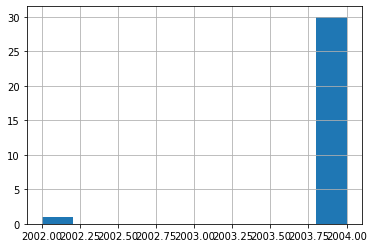

In [21]:
water_values['date_recorded'] = pd.to_datetime(water_values.date_recorded)
water_values['year_recorded'] = pd.DatetimeIndex(water_values.date_recorded).year
water_values.loc[water_values.year_recorded < water_values.construction_year]
water_values.loc[water_values.year_recorded == 2002].year_recorded.hist()

In [3]:
water_labels['target'] = water_labels.status_group.values
water_labels.drop('status_group', axis = 1, inplace = True)

In [4]:
#fixing dates 
median_con = water_values[water_values.construction_year != 0].construction_year.median()
water_values.construction_year.replace(0, median_con, inplace = True)
cons_year = water_values.construction_year.values 
rec_date = water_values.date_recorded.values 
def get_time_since_built(cons, rec): 
    time_array = []
    for c, r in zip(cons, rec): 
        r = int(r.split('-')[0])
        c = int(c)
        diff = r -c
        time_array.append(diff)
    return time_array

t_array = get_time_since_built(cons_year, rec_date)
water_values['time_passed'] = t_array
water_values.drop(['construction_year', 'date_recorded'], axis = 1, inplace = True)

In [11]:
water_values.head(2)

,id,amount_tsh,gps_height,installer,basin,region,lga,ward,population,public_meeting,permit,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,time_passed
0,69572,6000.0,1390,Roman,Lake Nyasa,Iringa,Ludewa,Mundindi,109,True,False,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,12
1,8776,0.0,1399,GRUMETI,Lake Victoria,Mara,Serengeti,Natta,280,NaN,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,3


In [15]:
#changes binary true-false to 0-1
water_values.public_meeting.fillna(False, inplace = True)
water_values.public_meeting = water_values.public_meeting.astype(int)
water_values.permit.fillna(False, inplace = True)
water_values.permit = water_values.permit.astype(int)
water_values.head(2)

,id,amount_tsh,gps_height,installer,basin,region,lga,ward,population,public_meeting,permit,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,time_passed
0,69572,6000.0,1390,Roman,Lake Nyasa,Iringa,Ludewa,Mundindi,109,1,0,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,12
1,8776,0.0,1399,GRUMETI,Lake Victoria,Mara,Serengeti,Natta,280,0,1,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,3


In [16]:
#fixing population to replace value with mdeian population within its basin 
from tqdm import tqdm
def fix_population_basin(df): 
    new_df = df
    for idx in tqdm(range(len(new_df))): 
        pop = new_df.iloc[idx].population 
        if pop != 0: 
            continue 
        basin_value = new_df.iloc[idx].basin
        basin_median_pop = new_df[(new_df.basin == basin_value) & (new_df.population > 0)].population.median() 
        new_df.loc[idx, 'population'] = basin_median_pop
        
    return new_df     

water_values = fix_population_basin(water_values)


100%|██████████| 59400/59400 [02:59<00:00, 330.20it/s]


In [17]:
#joining target with water_values
new_df = pd.merge(water_values, water_labels, on = 'id')

In [18]:
new_df.to_csv('data/WaterUpdated.csv', index = False)